In [75]:
import pandas as pd
import geopandas as gpd
import re
import nltk
from gensim.models.fasttext import FastText
from gensim.models import Word2Vec
import pickle
import tempun
import numpy as np
import matplotlib.pyplot as plt

In [2]:
GIST = gpd.read_parquet("../data/large_files/GIST_geocontexts.parquet")

In [3]:
len(GIST)

106898

In [4]:
GIST.sample(10)[["PHI_ID", "clean_text_interpretive_word", "lemmata", "raw_date", "not_before", "not_after", "random_dates","geometry"]]

,PHI_ID,clean_text_interpretive_word,lemmata,raw_date,not_before,not_after,random_dates,geometry
45043,230038,Πιρείθου,{'data': ['πιρείθου']},250-300 AD,250.0,300.0,"[253, 276, 254, 269, 283, 289, 268, 270, 273, ...",POINT (23.97015 38.14655)
90642,329982,Ἀριστοκλεῦς,{'data': ['ἀριστοκλεῦς']},3rd/2nd c. BC,-300.0,-101.0,"[-232, -223, -102, -233, -278, -277, -188, -28...",POINT (13.39384 37.44082)
29319,189689,αρόν ἐστιν ἐμὲ ὁμ ἀλλοδαποῖο ορος υἱός,"{'data': ['αἴρω', 'ἀλλοδαπός', 'ὀρός', 'υἱός']}",4th c. BC,-400.0,-301.0,"[-396, -352, -320, -335, -364, -371, -346, -30...",POINT (10.32722 36.85388)
21168,173949,Quintus Lutatius Rusticus,"{'data': ['quintus', 'lutatius', 'rusticus']}",2nd/3rd c. AD,101.0,300.0,"[199, 242, 263, 216, 121, 210, 240, 143, 134, ...",POINT (27.95169 44.68681)
31589,194194,βασιλέως Πύρρου τοῦ Αἰακίδα βασιλέως ἡγήτορος ...,"{'data': ['βασιλεύς', 'Πυρρός', 'Αἰακίδης', 'β...",ca. 291 BC?,-296.0,-286.0,"[-294, -289, -287, -293, -296, -289, -291, -29...",POINT (20.78937 39.54639)
79232,313618,Θεύδωρος Παριανὸς ἐποίησε,"{'data': ['θεύδωρος', 'παριανὸς', 'ποιέω']}",ca. 230 BC,-235.0,-225.0,"[-229, -229, -228, -230, -230, -233, -228, -23...",POINT (28.08818 36.09132)
105197,351838,ΟΙΛ δύο μέρη ου προσόδου πρακτὸν εἶναι ΕΦΟ,"{'data': ['οιλ', 'δύο', 'μέρος', 'πρόσοδος', '...",late 2nd c. AD,175.0,200.0,"[187, 180, 191, 180, 181, 187, 188, 189, 179, ...",POINT (27.27771 37.52158)
44292,228986,εχσις,{'data': ['εχσις']},ca. 520-510 BC,-521.0,-509.0,"[-515, -520, -516, -513, -518, -514, -510, -52...",POINT (30.59208 30.90031)
63755,291590,τὸ χωρίον ἀποδιδόναι μὲν τὴν μίσθωσιν ἑκάστου ...,"{'data': ['χωρίον', 'ἀποδίδωμι', 'μίσθωσις', '...",350-300 BC,-350.0,-300.0,"[-332, -325, -301, -329, -346, -343, -329, -33...",POINT (24.03865 37.87056)
80118,314706,βασιλεὺς Ἀντίοχος Μενεδήμωι χαῖρειν βουλόμενοι...,"{'data': ['βασιλεύς', 'ἀντίοχος', 'μενεδήμωι',...",193 BC,-193.0,-193.0,"[-193, -193, -193, -193, -193, -193, -193, -19...",POINT (48.36798 34.18761)


In [5]:
sum(GIST["polis?"])

70503

In [6]:
GIST_lemmata_merged = [[l for l in inscr_lem["data"]] for inscr_lem in GIST["lemmata"].tolist()]
GIST_lemmata_merged = [l for i in GIST_lemmata_merged for l in i]
len(GIST_lemmata_merged)

1648240

In [7]:
freqs_tups = nltk.FreqDist(GIST_lemmata_merged).most_common()
freqs_tups[:100]

[('δῆμος', 14979),
 ('θεός', 13267),
 ('πόλις', 12561),
 ('ἄλλος', 11026),
 ('ἔτος', 9281),
 ('βουλή', 7875),
 ('ἔχω', 6723),
 ('υἱός', 6261),
 ('εἰμί', 6229),
 ('αὐτός', 6069),
 ('ἄρχω', 5996),
 ('μείς', 5943),
 ('δοκέω', 5934),
 ('δίδωμι', 5796),
 ('ποιέω', 5397),
 ('πᾶς', 5332),
 ('χαίρω', 5308),
 ('ἀγαθός', 5307),
 ('οὗτος', 5272),
 ('γίγνομαι', 5045),
 ('ἀνήρ', 4832),
 ('Ἀπόλλων', 4815),
 ('δραχμή', 4526),
 ('ἀνατίθημι', 4472),
 ('ἱερόν', 4217),
 ('βασιλεύς', 4086),
 ('γυνή', 4058),
 ('χάρις', 4042),
 ('Ζεύς', 4009),
 ('ἱερεύς', 3930),
 ('et', 3844),
 ('σεβαστός', 3752),
 ('μέγας', 3492),
 ('αὐτοκράτωρ', 3482),
 ('ἄρχων', 3389),
 ('νόμος', 3369),
 ('Καῖσαρ', 3332),
 ('εὐεργέτης', 3327),
 ('λέγω', 3288),
 ('ἴδιος', 3224),
 ('ἱερός', 3178),
 ('τιμή', 3097),
 ('Διονύσιος', 3087),
 ('ψήφισμα', 3044),
 ('ὁλκή', 3038),
 ('φιάλη', 2893),
 ('Ἀπολλώνιος', 2875),
 ('μήτηρ', 2843),
 ('τὶς', 2838),
 ('πατήρ', 2782),
 ('Ἀθηναῖος', 2757),
 ('χρύσεος', 2757),
 ('στήλη', 2627),
 ('στέφανος', 2591

In [103]:
pd.DataFrame(freqs_tups[:5000]).to_csv("../data/freq_tups.csv")

In [8]:
pickle.dump(freqs_tups, open("../data/freqs_tups.pickle", "wb"))

In [9]:
match_pattern = "(κατα|ὑπό|ἐκ|ἀ|ἄ|ἀντί|^)δ[ι|ί]κ(α|ά|ο|ό|ί|έ|η)(.+)?"
dik_words = [word for word in GIST_lemmata_merged if re.search(match_pattern, word)]
dik_words_df = pd.DataFrame(nltk.FreqDist(dik_words).most_common(), columns=["lemma", "count"])
dik_words_df.head(5)

,lemma,count
0,δίκη,1153
1,δίκαιος,880
2,δικαστής,606
3,δικαιοσύνη,419
4,δικαστήριον,221


# Singular words explorations

In [101]:
religion = ["θεός", "Ζεύς", "εὐσέβεια", 'εὐσεβής', 'ἱερεύς'] # "ἱερόν", "ἱερός"

# "Διονύσιος", "Ἀπόλλων", "τιμή"
morality = ["ἀγαθός", "ἀρετή", "δίκαιος", "δίκη", 'δικαιοσύνη'] #, "δικαιοσύνη", "ἀλήθεια", "ἀληθής"]

In [28]:
for word in religion + morality:
    print(word, GIST_lemmata_merged.count(word))

θεός 13267
Ζεύς 4009
εὐσέβεια 875
εὐσεβής 1346
ἀγαθός 5307
ἀρετή 2428
δίκαιος 880
δικαιοσύνη 419


In [61]:
time_blocks = [[n, n+100] for n in range(-800, 410, 10)]
time_blocks[:3]

[[-800, -700], [-790, -690], [-780, -680]]

In [69]:
def sim_data_by_function(df, n_sims, time_blocks, function, args_dict=None, random_dates_column="random_dates"):
    complete_sim_data = []
    for n in range(n_sims):
        sim = df[random_dates_column].apply(lambda x: tempun.get_date_from_randoms(x, n))
        sim_data = []
        if isinstance(time_blocks[0],
                      int):  # if first entry of timeblocks is an integer it means that it is actually not a timeblock, but only the starting date of the first timeblock
            time_blocks = tempun.get_timeblocks(time_blocks[0], time_blocks[1], time_blocks[2])
        for tb in time_blocks:
            mask = sim.between(tb[0], tb[1])
            df_tb = df[mask]
            function_output = function(df_tb, args_dict)
            sim_data.append((tb, function_output))
        complete_sim_data.append(sim_data)
    return complete_sim_data

def get_word_frequency(timeblock_df, args_dict):
    word = args_dict["word"]
    all_lemmata = [[l for l in inscr_lem["data"]] for inscr_lem in timeblock_df["lemmata"].tolist()]
    all_lemmata = [l for i in all_lemmata for l in i]
    all_lemmata_N = len(all_lemmata)
    word_N = all_lemmata.count(word)
    word_freq = word_N / all_lemmata_N
    return np.round(word_freq, 5)

In [71]:
word_freq = sim_data_by_function(GIST, 10, time_blocks=time_blocks, function=get_word_frequency, args_dict={"word" : "θεός"})

[[<matplotlib.patches.Polygon at 0x2de2a8f10>],

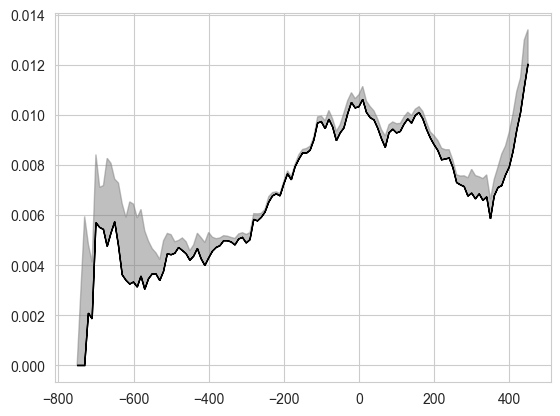

In [72]:
tempun.plot_timeblocks_data(word_freq)

In [74]:
%%time
sim_data_freq = {}
for word in religion + morality:
    word_freq = sim_data_by_function(GIST, 10, time_blocks=time_blocks, function=get_word_frequency, args_dict={"word": word})
    sim_data_freq[word] = word_freq

Text(-0.02, 0.5, 'word frequency')

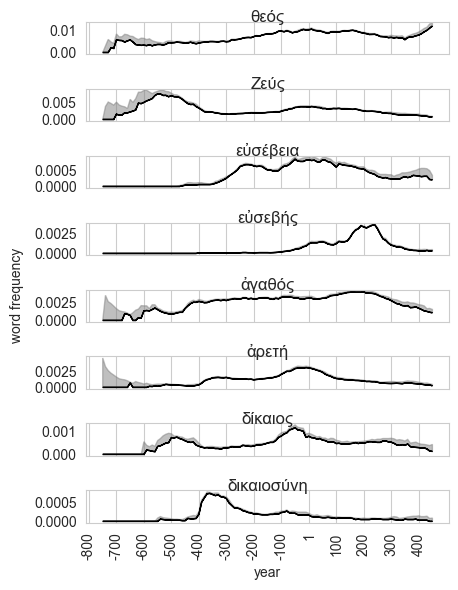

In [99]:
fig, axs = plt.subplots(8,1, figsize=(4.45, 6), tight_layout=True)

for word, ax in zip(religion + morality, axs.ravel()):
    tempun.plot_timeblocks_data(sim_data_freq[word], ax=ax)
    ax.set_xticklabels([])
    ax.grid(False, axis="y")
    ax.set_title(word, pad=-0.3)
    ax.set_xticks([el+1 if el==0 else el for el in range(-800,500,100)])
ax.set_xticklabels([str(el+1) if el==0 else str(el) for el in range(-800,500,100)], rotation=90)

ax.set_xlabel("year")

fig.text(-0.02, 0.5, 'word frequency', va='center', rotation='vertical')

# Building ngrams data

In [10]:
def get_ngrams(lemmata_data):
    lemmata_list = lemmata_data["data"]
    ngrams = []
    try:
        bigrams = list(nltk.ngrams(lemmata_list, 2))
        trigrams = list(nltk.ngrams(lemmata_list, 3, pad_right=True, pad_left=True))
        fivegrams = list(nltk.ngrams(lemmata_list, 5, pad_right=True, pad_left=True))
        ngrams_merged = bigrams + trigrams + fivegrams
        ngrams_merged = [[i for i in ngram if i is not None] for ngram in ngrams_merged]
        ngrams_merged = [ngram for ngram in ngrams_merged if (len(ngram) > 1)]
    except:
        ngrams_merged = [[]]
    return ngrams_merged


In [11]:
print(get_ngrams({"data" : ["lemma1", "lemma2", "lemma3", "lemma4", "lemma5", "lemma6"]}))

[['lemma1', 'lemma2'], ['lemma2', 'lemma3'], ['lemma3', 'lemma4'], ['lemma4', 'lemma5'], ['lemma5', 'lemma6'], ['lemma1', 'lemma2'], ['lemma1', 'lemma2', 'lemma3'], ['lemma2', 'lemma3', 'lemma4'], ['lemma3', 'lemma4', 'lemma5'], ['lemma4', 'lemma5', 'lemma6'], ['lemma5', 'lemma6'], ['lemma1', 'lemma2'], ['lemma1', 'lemma2', 'lemma3'], ['lemma1', 'lemma2', 'lemma3', 'lemma4'], ['lemma1', 'lemma2', 'lemma3', 'lemma4', 'lemma5'], ['lemma2', 'lemma3', 'lemma4', 'lemma5', 'lemma6'], ['lemma3', 'lemma4', 'lemma5', 'lemma6'], ['lemma4', 'lemma5', 'lemma6'], ['lemma5', 'lemma6']]


In [12]:
%%time
GIST["ngrams"] = GIST["lemmata"].apply(get_ngrams)

CPU times: user 4.03 s, sys: 223 ms, total: 4.25 s
Wall time: 4.43 s


In [29]:
GIST.head(5)

,PHI_ID,reference,metadata,lines,text_raw,text_iphi,clean_text_conservative,clean_text_interpretive_word,lemmata,raw_date,...,TMgeo_name,geometry,name,polis_geo,polis_dist,polis?,duration,random_dates,greece?,ngrams
0,1,IG I³\n1,Att. — Ath.: Akr. — stoich. 35 — c. 510-500 a....,12.0,ἔδοχσεν το͂ι δέμοι· τ̣[ὸς ἐ Σ]αλαμ̣[ῖνι κλερόχ...,εδοχσεν τοι δεμοι τ[ος ε σ]αλαμ[ινι κλεροχ]ος ...,ἔδοχσεν το͂ι δέμοι ταλαμος οἰκε͂ν ἐᾶ Σαλαμῖνι ...,ἔδοχσεν το͂ι δέμοι τὸς ἐ Σαλαμῖνι κλερόχος οἰκ...,"{'data': ['ἔδοχσεν', 'δέμοι', 'Σαλαμίς', 'κλερ...",c. 510-500 a.,...,Athenai,POINT (23.72399 37.97275),361-Athenai,"[23.7278, 37.9778]",653.43,True,13.0,"[-510, -504, -510, -507, -506, -500, -508, -50...",True,"[[ἔδοχσεν, δέμοι], [δέμοι, Σαλαμίς], [Σαλαμίς,..."
1,4,IG I³\n4,Att. — stoich. 38 — 485/4 a.,56.0,[․․․․․․․․․․․․․․․․․․38․․․․․․․․․․․․․․․․․․]\n[․․․...,[--------------------------------------] [----...,δέ τις αν ἒ φρορὰν μ ντέκοντα δχμὰς τ ας ℎες π...,ἐὰν δέ τις αν ἒ φρορὰν μὲ πεντέκοντα δραχμὰς τ...,"{'data': ['τὶς', 'φρορὰν', 'πεντέκοντα', 'δραχ...",485/4 a.,...,Athenai,POINT (23.72399 37.97275),361-Athenai,"[23.7278, 37.9778]",653.43,True,2.0,"[-485, -485, -485, -484, -485, -484, -485, -48...",True,"[[τὶς, φρορὰν], [φρορὰν, πεντέκοντα], [πεντέκο..."
2,5,IG I³\n5,Att. — c. 500 a.,6.0,[ἔδοχσε]ν [⋮ τε͂ι βολε͂ι] ⋮ καὶ [τ]ο͂ι δέμοι ⋮...,[εδοχσε]ν [ τει βολει] και [τ]οι δεμοι οτε παρ...,ν καὶ ο͂ι δέμοι ℎότε Παραιβάτες λεια θν τὸς ℎι...,ἔδοχσεν τε͂ι βολε͂ι καὶ το͂ι δέμοι ℎότε Παραιβ...,"{'data': ['ἔδοχσεν', 'τει', 'βολει', 'δέμοι', ...",c. 500 a.,...,Eleusis,POINT (23.54150 38.04414),362-Eleusis,"[23.5423, 38.0394]",530.31,True,11.0,"[-498, -502, -504, -503, -496, -504, -496, -49...",True,"[[ἔδοχσεν, τει], [τει, βολει], [βολει, δέμοι],..."
3,6,IG I³\n6,Att. — stoich. 23/11 — ante 460 a.,160.0,— — — — — — — — — — — — —\n[․․․․․․15․․․․․․․] δ...,------------- [---------------] δραχμεισ[ι ---...,δραχμε͂ιστες τὸς ιο μενος δεμο το͂ν πόλεο οκε͂...,δραχμε͂ισι τες τὸς ιο μενος δεμο το͂ν πόλεον δ...,"{'data': ['δραχμεισι', 'τες', 'μένος', 'δεμο',...",ante 460 a.,...,Eleusis,POINT (23.54150 38.04414),362-Eleusis,"[23.5423, 38.0394]",530.31,True,NaN,"[-461, -461, -461, -461, -461, -461, -461, -46...",True,"[[δραχμεισι, τες], [τες, μένος], [μένος, δεμο]..."
4,11,IG I³\n11,Att. — stoich. 48 — ante med. s. V a.,22.0,[χσυμμαχία καὶ ℎόρ]κ̣ο̣[ς] Ἀ̣[θ]ε̣ν̣α̣[ίον κα]...,[χσυμμαχια και ορ]κο[ς] α[θ]ενα[ιον κα]ι εγεστ...,κο Ἀεναὶ Ἐγεσταί ο͂ι ἐπρυτάνευε οΙ ον ἐ͂ρχε Ἀ...,χσυμμαχία καὶ ℎόρκος Ἀθεναίον καὶ Ἐγεσταίον ἔδ...,"{'data': ['χσυμμαχία', 'ὅρκος', 'ἀθεναίον', 'ἐ...",ante med. s. V a.,...,Athenai,POINT (23.72399 37.97275),361-Athenai,"[23.7278, 37.9778]",653.43,True,NaN,"[-456, -456, -456, -456, -456, -456, -456, -45...",True,"[[χσυμμαχία, ὅρκος], [ὅρκος, ἀθεναίον], [ἀθενα..."


In [30]:
%%time
f = open("../data/large_files/corpus_ngrams.txt", "w", encoding="utf-8")
line = 0
ids_lines = {}
for n in range(len(GIST)):
    id = str(GIST.iloc[n]["PHI_ID"])
    try:
        ngrams = [" ".join(ngram) for ngram in GIST.iloc[n]["ngrams"]]
        f.writelines("\n".join(ngrams)+"\n")
        ids_lines[id] = (line, line+len(ngrams))
        line += len(ngrams)
    except:
        print(id)

CPU times: user 17 s, sys: 773 ms, total: 17.8 s
Wall time: 18.7 s


In [31]:
pickle.dump(ids_lines, open("../data/ids_lines.pickle", "wb"))

In [32]:
class NgramCorpus:
    def __iter__(self):
        with open("../data/large_files/corpus_ngrams.txt", "r") as f:
            lines = f.readlines()
            for phi_id in ids_list:
                for line in lines[ids_lines[phi_id][0] : ids_lines[phi_id][1]]:
                    yield line.split()

In [33]:
ids_list = ["1","4","15","17"]

In [34]:
corpus = NgramCorpus()

In [30]:
len([doc for doc in corpus])

904

In [31]:
ids_list = GIST[GIST["random_dates"].apply(lambda x: -500 < x[0] < -401)]["PHI_ID"].astype("str").tolist()
len(ids_list)

6604

In [32]:
corpus = NgramCorpus()

In [33]:
corpus_len = len([doc for doc in corpus])
corpus_len

133348

In [34]:
N_tokens = sum([el[1] for el in freqs_tups])
N_tokens

1648240

In [35]:
N_types = len(freqs_tups)
N_types

214400

In [36]:
N_types_covered = 5000
N_tokens_covered = sum([el[1] for el in freqs_tups[:N_types_covered]])
N_tokens_covered / N_tokens

0.658017036353929

In [40]:
model = Word2Vec(vector_size=150, window=3, negative=5, ns_exponent=1, sg=0, epochs=10, workers=8)

In [41]:
model.build_vocab_from_freq(word_freq=dict(freqs_tups[:N_types_covered]))

In [42]:
%%time
model.train(corpus, total_examples=corpus_len, epochs=model.epochs)

CPU times: user 11.4 s, sys: 1.93 s, total: 13.3 s
Wall time: 13.3 s


(2138767, 4125460)

In [43]:
model.wv.most_similar("θεός")

[('λαμπρός', 0.677864670753479),
 ('παρθικοῦ', 0.6593357920646667),
 ('ἔνδοξος', 0.6470581889152527),
 ('αὐτοκράτωρ', 0.6440725922584534),
 ('ἁδριανοῦ', 0.6383450031280518),
 ('μέγας', 0.6350281834602356),
 ('ἐπιφανής', 0.6306490302085876),
 ('ἀρχιερεύς', 0.6289092898368835),
 ('σεβαστός', 0.6269497275352478),
 ('εὐχαριστέω', 0.6178341507911682)]

In [73]:
model = FastText(vector_size=150, window=3, negative=5, ns_exponent=1, sg=0, epochs=5, workers=8, min_n=4)
model.build_vocab_from_freq(word_freq=dict(freqs_tups[:N_types_covered]))
model.train(corpus, total_examples=corpus_len, epochs=model.epochs)

(3666485, 6064500)

In [76]:
model.wv.most_similar("θεός")

[('τεός', 0.8119252324104309),
 ('ἐτεός', 0.7080932855606079),
 ('σωτήριος', 0.6826785802841187),
 ('σωτήρ', 0.6691166758537292),
 ('παρθένιος', 0.6619709730148315),
 ('εὐσεβείαι', 0.6525436043739319),
 ('θέα', 0.642316460609436),
 ('προσκυνέω', 0.6290892362594604),
 ('ἐλευθέριος', 0.628943920135498),
 ('ἐπιφανής', 0.6255434155464172)]

# Developing century excluding models

In [77]:
for cent in range(-8, 8):
    if cent < 0:
        cent_start, cent_end = cent * 100, cent * 100 + 99
    else:
        cent_start, cent_end = cent * 100 + 1, cent * 100 + 100
    subset = GIST[GIST["random_dates"].apply(lambda x: cent_start < x[0] < cent_end)]
    print(cent_start, cent_end, (len(subset)))


-800 -701 63
-700 -601 382
-600 -501 2623
-500 -401 6604
-400 -301 9668
-300 -201 14232
-200 -101 13448
-100 -1 8443
1 100 9893
101 200 15986
201 300 11913
301 400 4897
401 500 2634
501 600 2271
601 700 421
701 800 126


In [78]:
cent_ids_samples = {}
for cent in range(-8, 6):
    if cent < 0:
        cent_start, cent_end = cent * 100, cent * 100 + 99
    else:
        cent_start, cent_end = cent * 100 + 1, cent * 100 + 100
    subset_ids = GIST[GIST["random_dates"].apply(lambda x: cent_start < x[0] < cent_end)]["PHI_ID"]
    subset_sample_ids = subset_ids.sample(1000, replace=True)
    cent_ids_samples[cent] = subset_sample_ids

In [79]:
# full_model
ids_list = []
for cent in cent_ids_samples.keys():
    ids_list.extend(list(cent_ids_samples[cent]))

In [80]:
len(ids_list)

14000

In [81]:
ids_list = [str(id) for id in ids_list]

In [82]:
corpus = NgramCorpus()

In [83]:
%%time
model = FastText(vector_size=150, window=3, negative=5, ns_exponent=1, sg=0, epochs=5, workers=8, min_n=3)
model.build_vocab_from_freq(word_freq=dict(freqs_tups[:N_types_covered]))
model.train(corpus, total_examples=corpus_len, epochs=model.epochs)

CPU times: user 23 s, sys: 1.76 s, total: 24.7 s
Wall time: 12.6 s


(4446799, 7471415)

In [84]:
model.wv.most_similar("θεός", topn=100)

[('ἐτεός', 0.8190017342567444),
 ('τεός', 0.8043358325958252),
 ('ἰατρός', 0.7662969827651978),
 ('κολωνός', 0.7587723135948181),
 ('θεαρός', 0.7583391666412354),
 ('σεμνός', 0.7576870322227478),
 ('ἁγνός', 0.7523812055587769),
 ('τρυφερός', 0.7308467030525208),
 ('γαμβρός', 0.7302103638648987),
 ('γεραιός', 0.7300339937210083),
 ('μανός', 0.7294237613677979),
 ('σεισμός', 0.729305624961853),
 ('λυγρός', 0.7234829068183899),
 ('ζοός', 0.7187726497650146),
 ('δημιουργός', 0.7179083824157715),
 ('θοός', 0.7178543210029602),
 ('ληνός', 0.7176640629768372),
 ('ἀγρός', 0.7155147790908813),
 ('ἱλαρός', 0.7150009274482727),
 ('λαός', 0.7125334143638611),
 ('ὀρός', 0.7107135653495789),
 ('θεσμός', 0.7100199460983276),
 ('θιός', 0.7094550132751465),
 ('γεωργός', 0.7089586853981018),
 ('ψυχρός', 0.7078760862350464),
 ('ἑός', 0.7073254585266113),
 ('ἰτός', 0.7069397568702698),
 ('δεινός', 0.7067515254020691),
 ('βροτός', 0.7054709196090698),
 ('γοργός', 0.7036975026130676),
 ('ζωός', 0.7019622325

In [85]:
model.wv.save("../data/large_files/vectors_fasttext/model_full.wv")

In [87]:
for cent_to_exclude in cent_ids_samples.keys():
    ids_list = []
    for key in cent_ids_samples.keys():
        if key != cent_to_exclude:
            ids_list.extend(list(cent_ids_samples[key]))
    ids_list = [str(id) for id in ids_list]
    model = FastText(vector_size=150, window=3, negative=5, ns_exponent=1, sg=0, epochs=5, workers=8, min_n=3)
    model.build_vocab_from_freq(word_freq=dict(freqs_tups[:N_types_covered]))
    print("going to train model excluding {} century".format(str(cent_to_exclude)))
    model.train(corpus, total_examples=corpus_len, epochs=model.epochs)
    model.wv.save("../data/large_files/vectors_fasttext/model_without_{}.wv".format(str(cent_to_exclude)))

going to train model excluding -8 century
going to train model excluding -7 century
going to train model excluding -6 century
going to train model excluding -5 century
going to train model excluding -4 century
going to train model excluding -3 century
going to train model excluding -2 century
going to train model excluding -1 century
going to train model excluding 0 century
going to train model excluding 1 century
going to train model excluding 2 century
going to train model excluding 3 century
going to train model excluding 4 century
going to train model excluding 5 century
